In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.io as pio
pio.renderers.default = 'svg'

In [2]:
# Loading the datasets

airport_df = pd.read_csv('Assignment5Datasets/complaints-by-airport.csv')
category_df = pd.read_csv('Assignment5Datasets/complaints-by-category.csv')
subcategory_df = pd.read_csv('Assignment5Datasets/complaints-by-subcategory.csv')
lookup_df = pd.read_csv('Assignment5Datasets/iata-icao.csv')

In [3]:
airport_df.head()

,pdf_report_date,airport,year_month,count
0,2019-02,ABE,2015-01,0
1,2019-02,ABE,2015-02,0
2,2019-02,ABE,2015-03,0
3,2019-02,ABE,2015-04,0
4,2019-02,ABE,2015-05,2


In [4]:
category_df.head()

,pdf_report_date,airport,category,year_month,count,clean_cat,clean_cat_status
0,2019-02,ABE,Hazardous Materials Safety,2015-01,0,Hazardous Materials Safety,original
1,2019-02,ABE,Mishandling of Passenger Property,2015-01,0,Mishandling of Passenger Property,original
2,2019-02,ABE,Hazardous Materials Safety,2015-02,0,Hazardous Materials Safety,original
3,2019-02,ABE,Mishandling of Passenger Property,2015-02,0,Mishandling of Passenger Property,original
4,2019-02,ABE,Hazardous Materials Safety,2015-03,0,Hazardous Materials Safety,original


In [5]:
subcategory_df.head()

,pdf_report_date,airport,category,subcategory,year_month,count,clean_cat,clean_subcat,clean_cat_status,clean_subcat_status,is_category_prefix_removed
0,2019-02,ABE,Hazardous Materials Safety,General,2015-01,0,Hazardous Materials Safety,General,original,original,False
1,2019-02,ABE,Mishandling of Passenger Property,Damaged/Missing Items--Checked Baggage,2015-01,0,Mishandling of Passenger Property,*Damaged/Missing Items--Checked Baggage,original,original,False
2,2019-02,ABE,Hazardous Materials Safety,General,2015-02,0,Hazardous Materials Safety,General,original,original,False
3,2019-02,ABE,Mishandling of Passenger Property,Damaged/Missing Items--Checked Baggage,2015-02,0,Mishandling of Passenger Property,*Damaged/Missing Items--Checked Baggage,original,original,False
4,2019-02,ABE,Hazardous Materials Safety,General,2015-03,0,Hazardous Materials Safety,General,original,original,False


In [6]:
lookup_df.head()

,country_code,region_name,iata,icao,airport,latitude,longitude
0,AE,Abu Zaby,AAN,OMAL,Al Ain International Airport,24.2617,55.6092
1,AE,Abu Zaby,AUH,OMAA,Abu Dhabi International Airport,24.4330,54.6511
2,AE,Abu Zaby,AYM,NaN,Yas Island Seaplane Base,24.4670,54.6103
3,AE,Abu Zaby,AZI,OMAD,Al Bateen Executive Airport,24.4283,54.4581
4,AE,Abu Zaby,DHF,OMAM,Al Dhafra Air Base,24.2482,54.5477


In [7]:
# Checking for missing values in the datasets

all_dfs = [
    ("airport_df", airport_df),
    ("category_df", category_df),
    ("subcategory_df", subcategory_df),
    ("lookup_df", lookup_df),
]

for name, df in all_dfs:
    missing_counts = df.isnull().sum() # count NaNs for each column
    missing_counts = missing_counts[missing_counts > 0] # keep only columns with > 0 missing
    
    if not missing_counts.empty:
        print(f"\n{name} has missing data:")
        for col, cnt in missing_counts.items():
            print(f"  • {col}: {cnt} missing")
    else:
        print(f"\n{name} has no missing data.")



airport_df has missing data:
  • airport: 109 missing

category_df has missing data:
  • airport: 4042 missing

subcategory_df has missing data:
  • airport: 13464 missing

lookup_df has missing data:
  • country_code: 32 missing
  • icao: 1143 missing


In [8]:
for name, df in all_dfs:
    rows, cols = df.shape
    print(f"{name} shape: {rows} rows × {cols} columns")

airport_df shape: 41721 rows × 4 columns
category_df shape: 241588 rows × 7 columns
subcategory_df shape: 504512 rows × 11 columns
lookup_df shape: 8937 rows × 7 columns


In [9]:
# The missing rows for each dataset are very small relative to each dataset's size. Also, missing airport values in the complaints datasets, according to the 
# documentation from the GitHub repo, are complaints which are not associated with any airport in particular. These will not be useful in this assignment anyway
# so let's just drop them. The lookup_df will remain as is for the time being, we will use its iata column (that isn't missing any) for looking up 

airport_df.dropna(inplace=True)
category_df.dropna(inplace=True)
subcategory_df.dropna(inplace=True)

In [10]:
# Let's go ahead and get a full list of columns contained in each dataset 

for name, df in all_dfs:
    cols = df.columns
    print(f'{name} : {cols}')

airport_df : Index(['pdf_report_date', 'airport', 'year_month', 'count'], dtype='object')
category_df : Index(['pdf_report_date', 'airport', 'category', 'year_month', 'count',
       'clean_cat', 'clean_cat_status'],
      dtype='object')
subcategory_df : Index(['pdf_report_date', 'airport', 'category', 'subcategory', 'year_month',
       'count', 'clean_cat', 'clean_subcat', 'clean_cat_status',
       'clean_subcat_status', 'is_category_prefix_removed'],
      dtype='object')
lookup_df : Index(['country_code', 'region_name', 'iata', 'icao', 'airport', 'latitude',
       'longitude'],
      dtype='object')


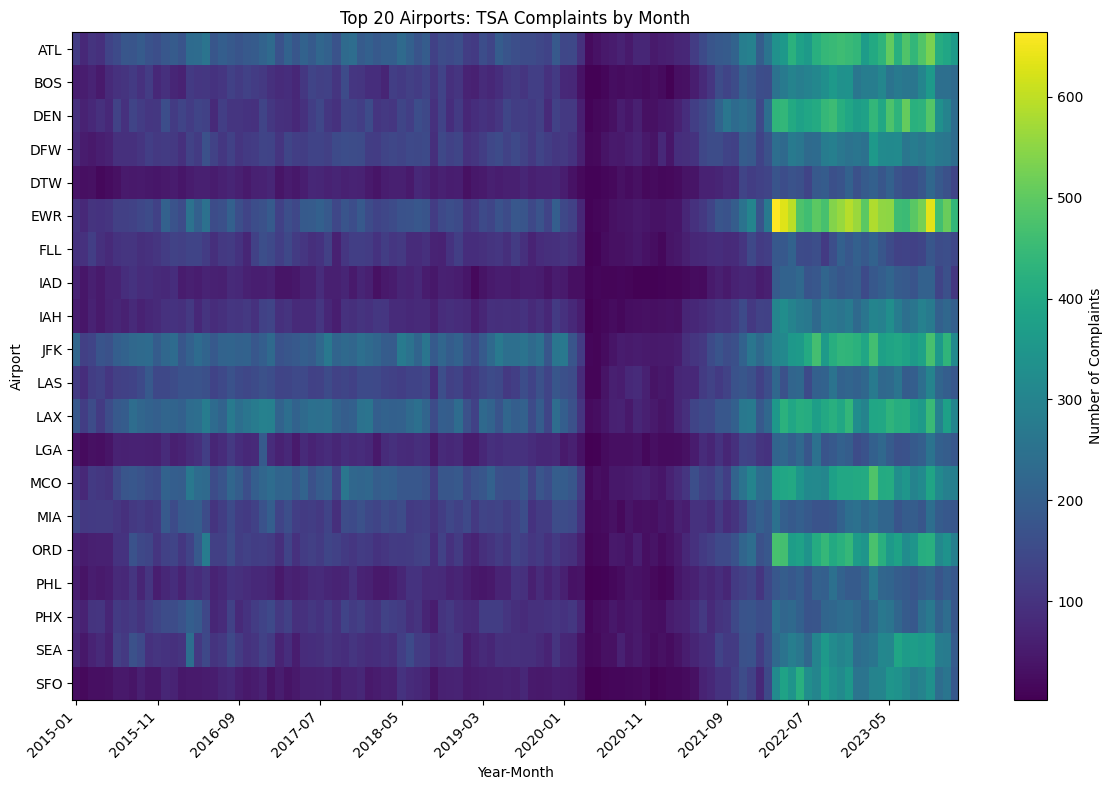

In [11]:
# VISUALIZATION 1: Heatmap using ariport_df
# We'll first need to pivot the airport_df such that the index = airport, column = year_month, and value = count

# Will need math for evenly spacing out the x-axis
import math

# Let's do only the top 20 busiest airports to avoid a cluttered heatmap
top20 = (
    airport_df
    .groupby("airport")["count"]
    .sum()
    .nlargest(20)
    .index
)

# Pivot only those busiest airports
airport_pivot = (
    airport_df[airport_df["airport"].isin(top20)]
    .pivot(index="airport", columns="year_month", values="count")
    .fillna(0)
)

# Converting month_year to datetime and sorting chronologically
airport_pivot.columns = pd.to_datetime(airport_pivot.columns, format="%Y-%m")
airport_pivot = airport_pivot.sort_index(axis=1)

# Computing even tick locations for the x-axis to avoid overcrowding
n_months = airport_pivot.shape[1] # getting total # months (should be 109)
max_labels = 12 # no more than 12 labels
step = math.ceil(n_months / max_labels) # getting how many months it should skip each time to get 12 evenly-spaced ticks
tick_locs = np.arange(0, n_months, step)  # this gets the evenly-spaced array given our specific data

# Grabbing the labels for those positions
# First formatting them back to YYYY-MM strings as before
tick_labels = [
    airport_pivot.columns[i].strftime("%Y-%m")
    for i in tick_locs
]

# Plotting the heatmap
fig, ax = plt.subplots(figsize=(12, 8))

# imshow will by default use a perceptually-uniform colormap
im = ax.imshow(airport_pivot, aspect="auto")

# label ticks
ax.set_xticks(tick_locs)
ax.set_xticklabels(tick_labels, rotation=45, ha="right")
ax.set_yticks(np.arange(airport_pivot.shape[0]))
ax.set_yticklabels(airport_pivot.index)

# axis labels and title
ax.set_xlabel("Year-Month")
ax.set_ylabel("Airport")
ax.set_title("Top 20 Airports: TSA Complaints by Month")

# colorbar on the side
fig.colorbar(im, ax=ax, label="Number of Complaints")

plt.tight_layout()
plt.show()

We can see a very clear global drop in complaints corresponding with the Covid pandemic. It is also clear that the years following the Covid slowdown showed a dramatic increase in the number of reports than before Covid. Reading through the GitHub documentation for these datasets, it was mentioned that this increase in raw count complaints is likely due to operational changes at TSA that made filing complaints much easier for passengers. Interestingly, a handful of airports seem to have maintained similar complaint reports to their pre-Covid norms such as Detroit Metro Airport (DTW), Fort Lauderdale-Hollywood (FLL) and LaGuardia Airport (LGA), to name a few.

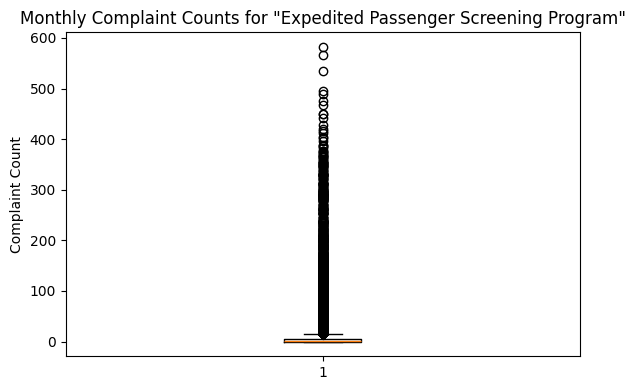

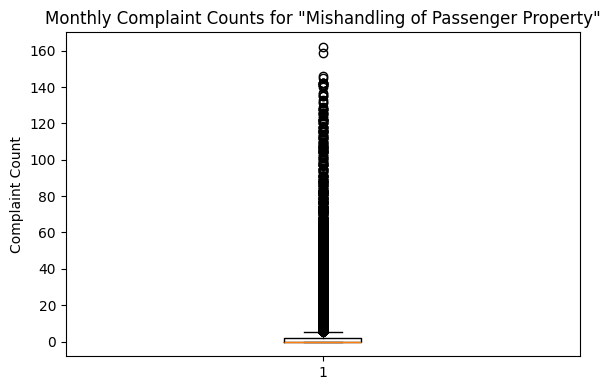

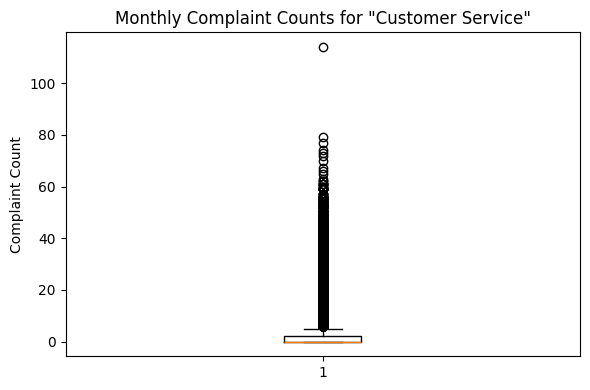

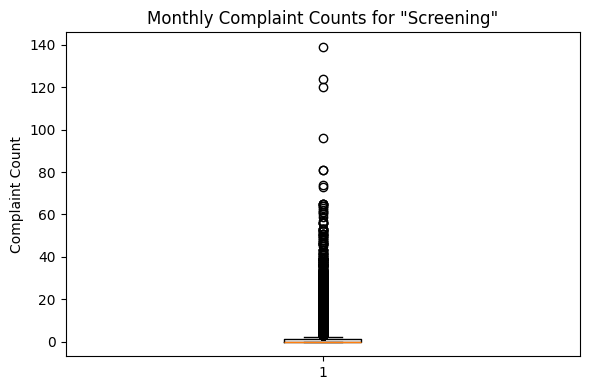

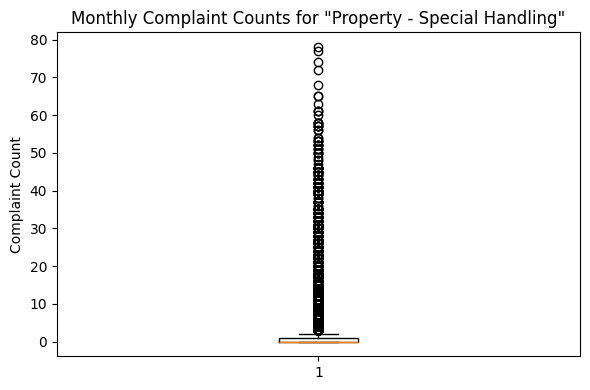

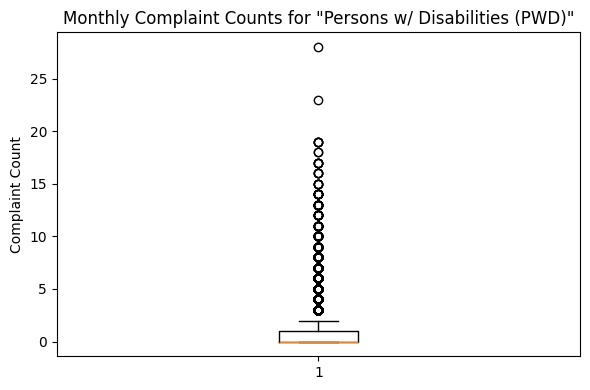

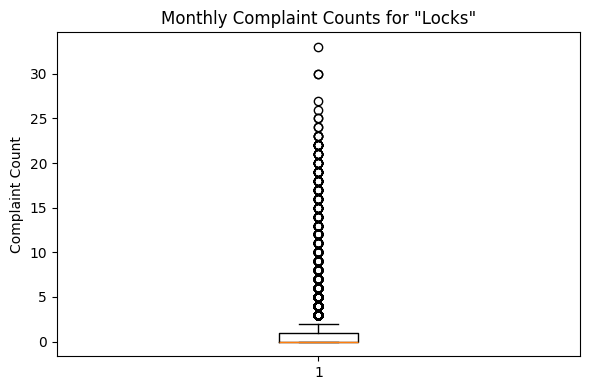

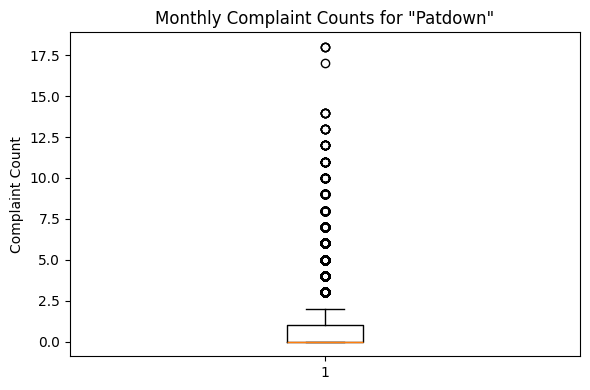

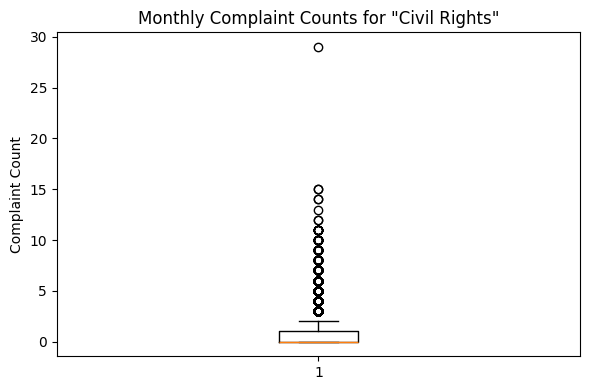

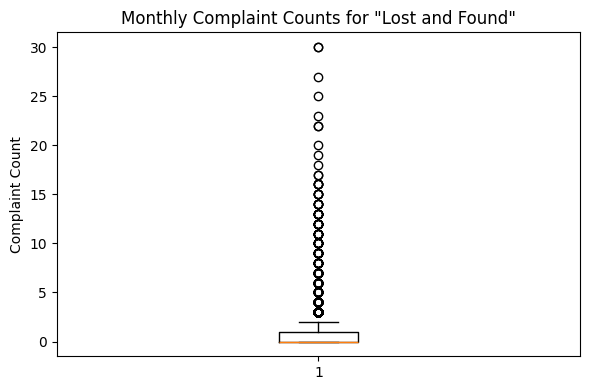

In [12]:
# VISUALIZATION 2: Box plots of monthly complaint counts by general category using category_df

# Preparing the data, using a copy of the category_df just in case so we can leave the original intact
df = category_df.copy()

# Identifying the top 10 categories by total complaints
top10 = (
    df.groupby('clean_cat')['count']
      .sum()
      .nlargest(10)
      .index
      .tolist()
)

# Looping and plotting each one separately since the scales between some of the categories vary widely
for cat in top10:
    counts = df.loc[df['clean_cat'] == cat, 'count']
    plt.figure(figsize=(6, 4))
    plt.boxplot(counts, showfliers=True)
    plt.title(f'Monthly Complaint Counts for "{cat}"')
    plt.ylabel('Complaint Count')
    plt.tight_layout()
    plt.show()

I decided to make multiple box plots for the top 10 general complaint categories. When plotted together on the same scale, many of the categories weren't able to convey any real information because the scale was too large. We can clearly see that all complaint categories have many outliers well above the IQR and top whisker, suggesting the 

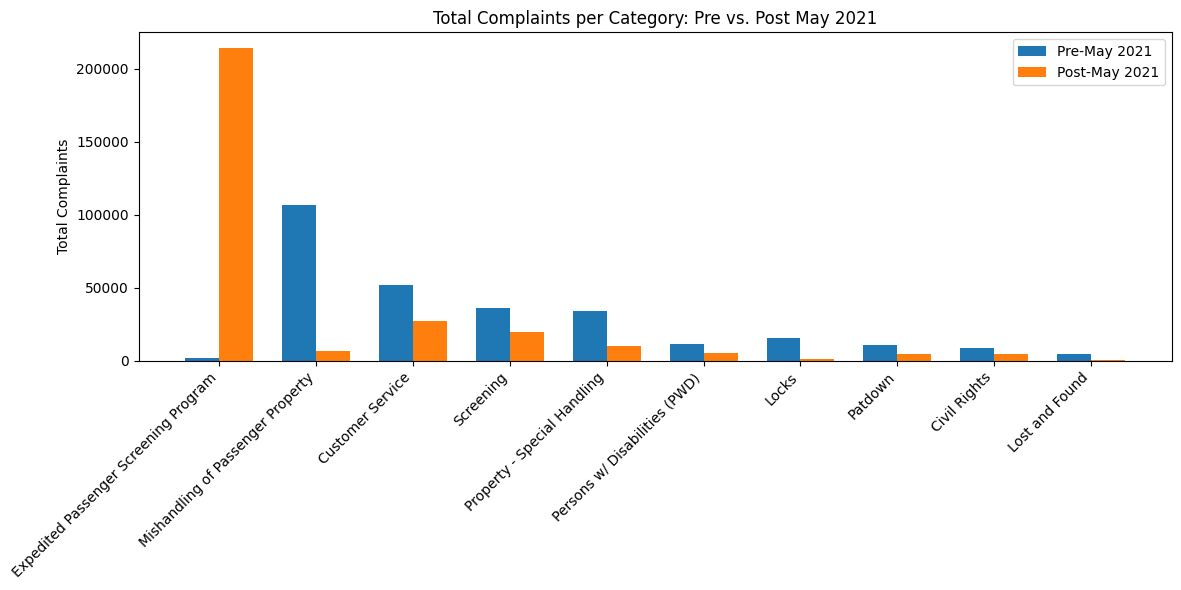

In [13]:
# VISUALIZATION 3: Paired bar chart of the top 10 categories by pre-TSA reporting change and post-change

# Convertting year_month to datetime
df['year_month'] = pd.to_datetime(df['year_month'], format='%Y-%m')

# Splitting into pre- and post-May 2021
cutoff = pd.to_datetime('2021-05-01')
pre = df[df['year_month'] < cutoff]
post = df[df['year_month'] >= cutoff]

# Summing complaints by category for each period
pre_sum  = pre.groupby('clean_cat')['count'].sum()
post_sum = post.groupby('clean_cat')['count'].sum()

# Identifying top 10 categories by combined total
total = pre_sum.add(post_sum, fill_value=0)
top10 = total.nlargest(10).index.tolist()

# Building a df for plotting
plot_df = pd.DataFrame({
    'Pre-May 2021': pre_sum.reindex(top10, fill_value=0),
    'Post-May 2021': post_sum.reindex(top10, fill_value=0),
}, index=top10)

# Plotting paired bar chart
x = np.arange(len(top10))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width/2, plot_df['Pre-May 2021'], width, label='Pre-May 2021')
ax.bar(x + width/2, plot_df['Post-May 2021'], width, label='Post-May 2021')

ax.set_xticks(x)
ax.set_xticklabels(top10, rotation=45, ha='right')
ax.set_ylabel('Total Complaints')
ax.set_title('Total Complaints per Category: Pre vs. Post May 2021')
ax.legend()
plt.tight_layout()
plt.show()

So it looks like Expedited Passenger Screening Program (EPSP) jumped significantly post-May 2021 while all other categories decreased. This might be because of two factors. First, it is possible that the EPSP was instituted at the same time as the reporting changes and many of the complaints that would otherwise have been assigned to another category were rerouted to be EPSP complaints. The second factor could be a result of lower overall travel during and shortly after the Covid pandemic, leading to lower overall complaints in the other categories other than EPSP. It is possible both of these factors are at play, so let's look a little closer.

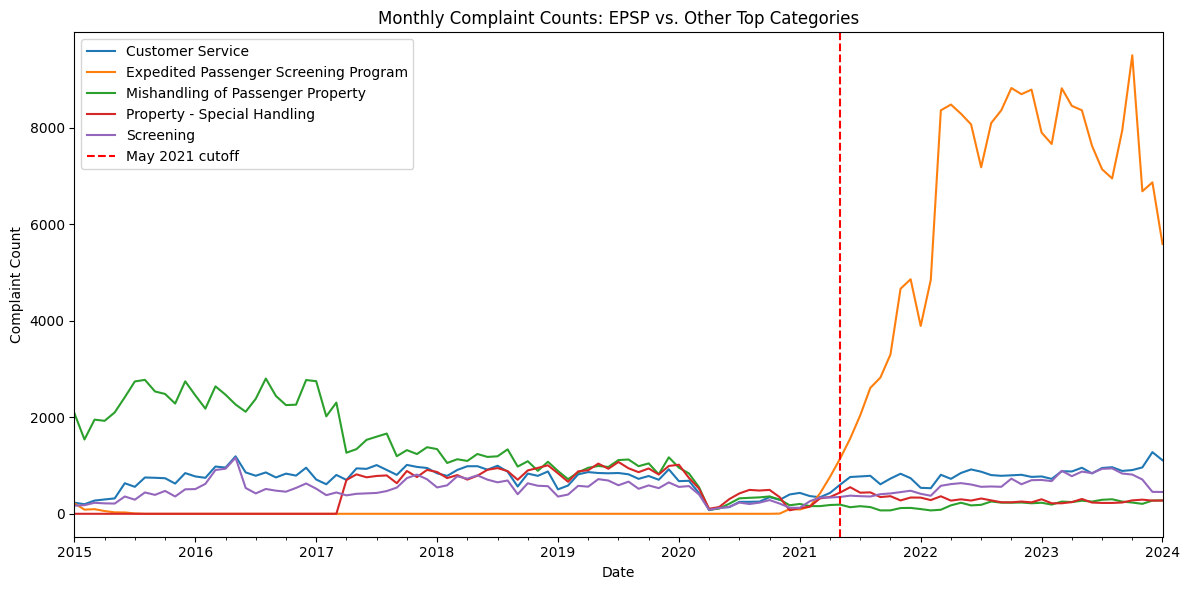

In [14]:
# VISUALIZATION 3: Time series for a couple categories to compare EPSP to other common categories 

# Selecting just the next 4 most common complaint categories to compare to EPSP
cats = [
    'Expedited Passenger Screening Program',
    'Mishandling of Passenger Property',
    'Customer Service',
    'Screening',
    'Property - Special Handling'
]

# Filtering and summing per month
monthly_sel = (
    df[df['clean_cat'].isin(cats)]
    .groupby(['year_month','clean_cat'])['count']
    .sum()
    .reset_index()
)

# Pivoting so each category is its own column, needed for the time series line graph
ts_pivot = (
    monthly_sel
    .pivot(index='year_month', columns='clean_cat', values='count')
    .fillna(0)
)

# Plotting the lines with a vertical cutoff marker to clearly indicate time of the TSA reporting changes
fig, ax = plt.subplots(figsize=(12, 6))
ts_pivot.plot(ax=ax)
ax.axvline(pd.to_datetime('2021-05-01'), color='red', linestyle='--', label='May 2021 cutoff')
ax.set_title('Monthly Complaint Counts: EPSP vs. Other Top Categories')
ax.set_ylabel('Complaint Count')
ax.set_xlabel('Date')
ax.legend()
plt.tight_layout()
plt.show()

We can clearly see the early 2020 drop in almost all complaint data due to Covid shutdowns. As air travel ramped back up in the years following the pandemic, it is clear that EPSP complaints blew up while most of the other categories did not quite return to their pre-Covid levels. This suggests some amount of rerouting of complaints to the EPSP but also a greater number of complaints overall, which is what we expected following the TSA changes making it easier to filing complaints. 

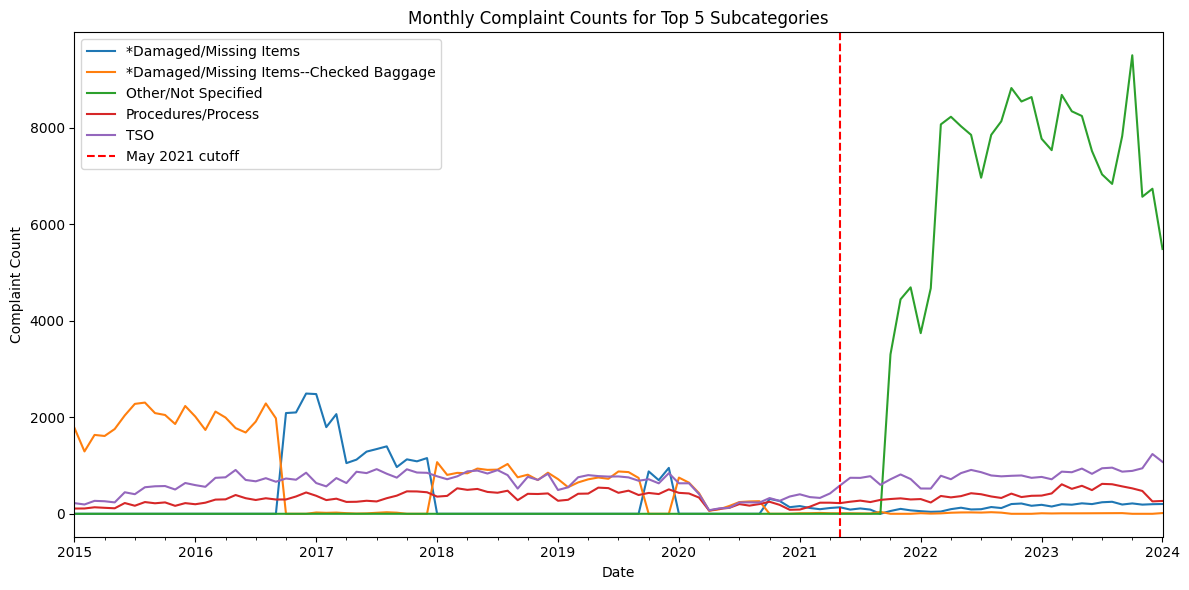

In [15]:
# VISUALIZATION 4: Line chart with cut-over for the top 5 subcategories using subcategory_df

# Making a copy just in case, leaving the original untouched
df = subcategory_df.copy()

# Renaming the missing values for clean_subcat as Other/Not Specified
df['clean_subcat'] = df['clean_subcat'].replace('*', 'Other/Not Specified')

# Converting 'year_month' to datetime
df['year_month'] = pd.to_datetime(df['year_month'], format='%Y-%m')

# Identifying the top 5 subcategories by total complaint count
top5 = (
    df.groupby('clean_subcat')['count']
      .sum()
      .nlargest(5)
      .index
      .tolist()
)

# Filtering to just those top 5
df_top5 = df[df['clean_subcat'].isin(top5)]

# Aggregating monthly sums
monthly_subcat = (
    df_top5
    .groupby(['year_month','clean_subcat'])['count']
    .sum()
    .reset_index()
)

# Pivoting so each subcategory is its own column, needed for the line plot
ts = (
    monthly_subcat
    .pivot(index='year_month', columns='clean_subcat', values='count')
    .fillna(0)
)

# Plotting the time series with a vertical cutoff at May 2021, just like before
fig, ax = plt.subplots(figsize=(12, 6))
ts.plot(ax=ax)
ax.axvline(pd.to_datetime('2021-05-01'), color='red', linestyle='--', label='May 2021 cutoff')
ax.set_title('Monthly Complaint Counts for Top 5 Subcategories')
ax.set_xlabel('Date')
ax.set_ylabel('Complaint Count')
ax.legend()
plt.tight_layout()
plt.show()

The time series line graph with the top 5 subcategories seems to support the idea that there is likely a combination of the two factors mentioned before at play here. The other/not specified category was constantly 0 up until mid 2021 when it went vertical. At the same time, the subcategories referring to different kinds of damaged/missing items complaints were muted, suggesting many of those complaints began getting categorized as something else. Overall complaints still exploded at this time as well, almost exclusively via the other/not specified subcategory. 

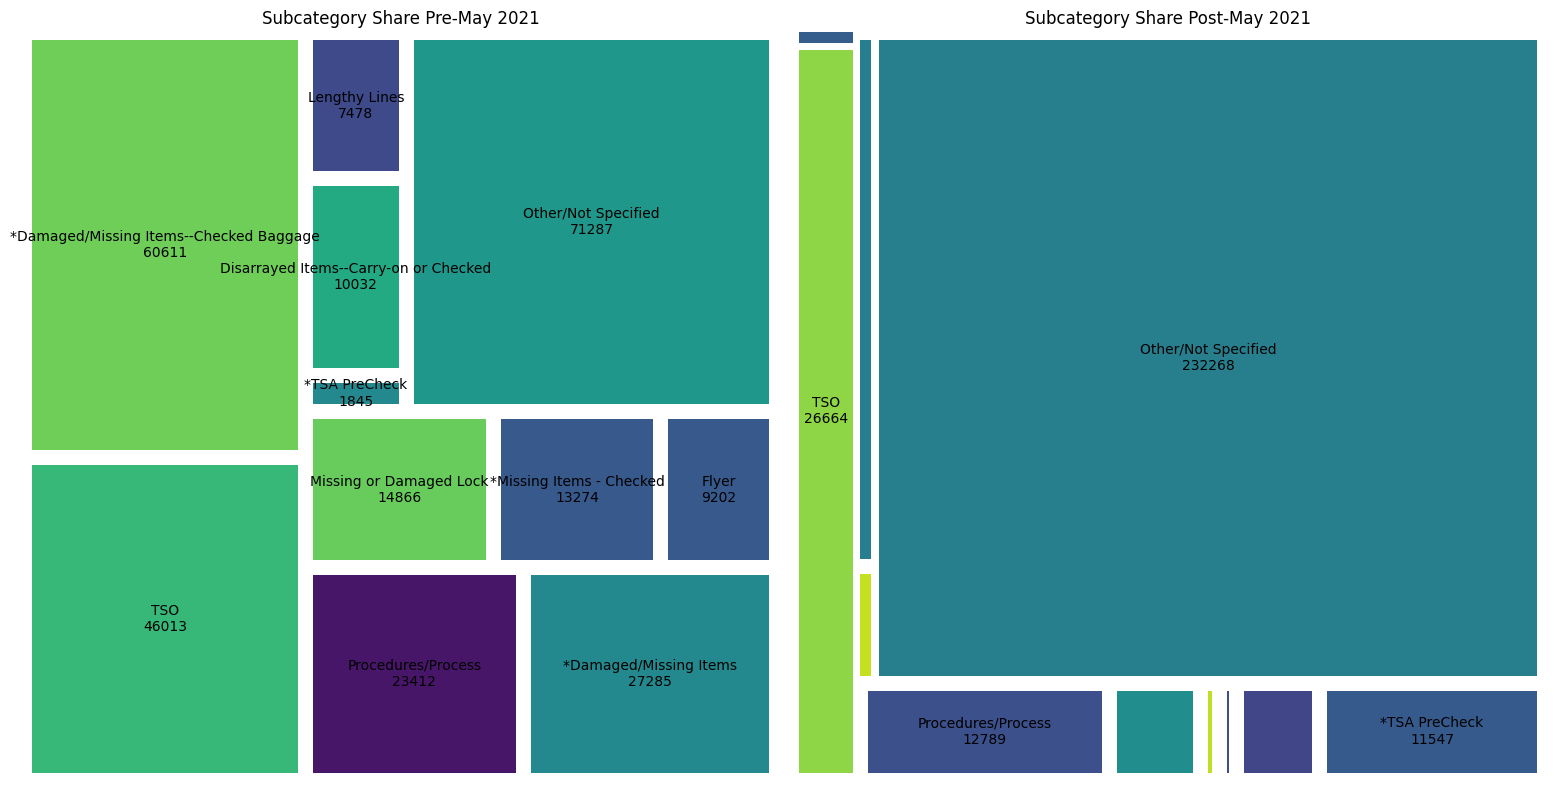

In [16]:
# VISUALIZATION 5: Paired tree maps for pre- and post-May 2021 TSA changes using subcategory_df

import squarify

# Starting with a fresh copy of subcategory_df 
df = subcategory_df.copy()

# Putting 'year_month' into datetime
df['year_month'] = pd.to_datetime(df['year_month'], format='%Y-%m')

# Splitting into pre- and post-May 2021
cutoff = pd.to_datetime('2021-05-01')
pre  = df[df['year_month'] < cutoff]
post = df[df['year_month'] >= cutoff]

# Summing complaints by subcategory in each period
pre_sum  = pre.groupby('clean_subcat')['count'].sum().sort_values(ascending=False)
post_sum = post.groupby('clean_subcat')['count'].sum().sort_values(ascending=False)

# Choosing top 10 subcategories by combined total
combined = (pre_sum + post_sum).sort_values(ascending=False)
top10 = combined.head(10).index.tolist()

# Reindexing sums for top 10 and compute "Other"
pre_top10  = pre_sum.reindex(top10).fillna(0)
post_top10 = post_sum.reindex(top10).fillna(0)
pre_other  = pre_sum.drop(top10).sum()
post_other = post_sum.drop(top10).sum()

pre_values  = list(pre_top10.values)  + [pre_other]
pre_labels  = list(pre_top10.index)   + ['Other/Not Specified']
post_values = list(post_top10.values) + [post_other]
post_labels = list(post_top10.index)  + ['Other/Not Specified']

# Computing a threshold so we only label slices > 2% of total (the second tree map had some bad overcrowding with the smaller boxes)
total_post = sum(post_values)
label_threshold = 0.02  # 2%

# Build smarter labels: show label + count only if slice > threshold, else empty
post_smart_labels = [
    f"{lab}\n{val}" if (val / total_post) > label_threshold else ""
    for lab, val in zip(post_labels, post_values)
]

# Plotting the paired treemaps
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Pre-May
squarify.plot(
    sizes=pre_values,
    label=[f"{lab}\n{val}" for lab, val in zip(pre_labels, pre_values)],
    ax=axes[0],
    pad=True,
    text_kwargs={'fontsize':10}
)
axes[0].set_title('Subcategory Share Pre-May 2021')
axes[0].axis('off')

# Post-May with smarter labels
squarify.plot(
    sizes=post_values,
    label=post_smart_labels,
    ax=axes[1],
    pad=True,
    text_kwargs={'fontsize':10} 
)
axes[1].set_title('Subcategory Share Post-May 2021')
axes[1].axis('off')

plt.tight_layout()
plt.show()

This tree map comparison is pretty telling. We can clearly see that many of the top subcategories from pre-May 2021 are practically missing in the post-May 2021 tree map while the latter's Other/Not Specified box more than tripled. I even had to fix how I labeled the second tree map because of how small and overcrowded the less common subcategories became. This really suggest that those subcategories are being rerouted and labeled differently in the TSA reporting system, probably under a more general field like EPSP in the category_df dataset. If this is the case, it seems that TSA complaints may have become easier to file but they are being filed under a blanket category, possibly making it harder to discover specific problematic trends in airport performance.

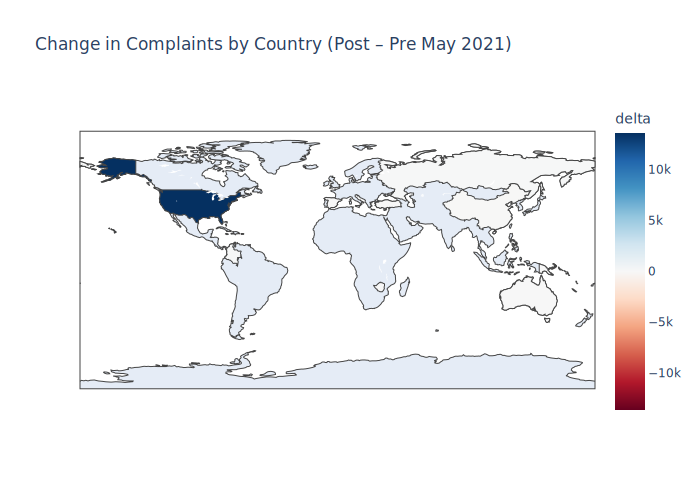

In [18]:
# VISUALIZATION 6: Choropleth maps comparing complaints by volume using airport_df and lookup_df, plotly and pycountry libraries

import plotly.express as px
import pycountry

# Let's work with copies again
airport = airport_df.copy()
lookup  = lookup_df.copy()

# Merging and converting to datetime
df = airport.merge(lookup[['iata','country_code']],
                  left_on='airport', right_on='iata', how='left')
df['year_month'] = pd.to_datetime(df['year_month'], format='%Y-%m')

# Mapping ISO-2 to ISO-3, needed for plotly maps
iso2_to_iso3 = {c.alpha_2: c.alpha_3 for c in pycountry.countries}
df['iso3'] = df['country_code'].map(iso2_to_iso3)
df = df.dropna(subset=['iso3'])

# Splitting pre/post May 2021
cutoff = pd.to_datetime('2021-05-01')
pre  = df[df['year_month'] <  cutoff]
post = df[df['year_month'] >= cutoff]

# Aggregating those time periods
pre_sum  = pre.groupby('iso3', as_index=False)['count'].sum().rename(columns={'count':'pre'})
post_sum = post.groupby('iso3', as_index=False)['count'].sum().rename(columns={'count':'post'})

# Merging for diffs
diff = pre_sum.merge(post_sum, on='iso3', how='outer').fillna(0)
diff['delta'] = diff['post'] - diff['pre']      # delta will be our raw change in complaint counts
diff['pct_change'] = diff['delta'] / diff['pre'].replace(0, np.nan)     # calculating the actual percent change

# Choropleth of absolute change in complaint counts
max_abs = np.max(np.abs(diff['delta']))
fig1 = px.choropleth(
    diff,
    locations='iso3',
    locationmode='ISO-3',
    color='delta',
    color_continuous_scale='RdBu',
    range_color=[-max_abs, max_abs],
    title='Change in Complaints by Country (Post – Pre May 2021)'
)
fig1.show()

So that didn't really show us anything we didn't already know. The US dominates the dataset in terms of complaints. Importantly, it doesn't look like any country saw a decrease in total complaints in the post-May 2021 time period. I'm going to make a second choropleth that takes the log of post-May 2021 complaints so that we can hopefully see a more useful comparison between countries and their complaint volumes.

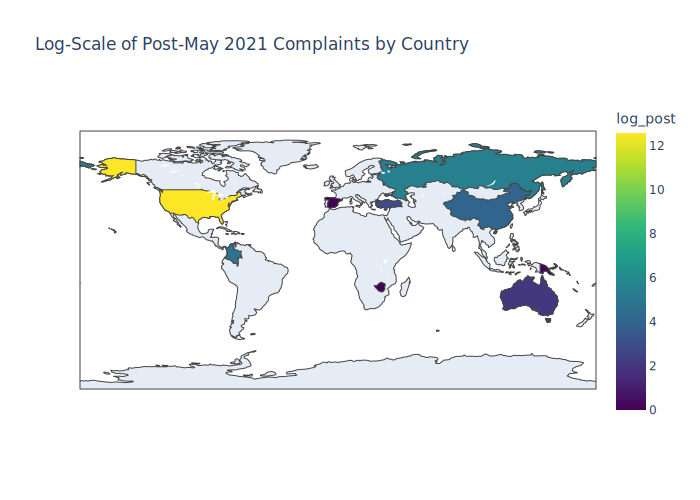

In [19]:
# Second choropleth: Log of post complaint sums for each country

# Making a new variable log_post for our choropleth 
diff['log_post'] = np.log1p(diff['post'])

# Plotting it
fig2 = px.choropleth(
    diff,
    locations='iso3',
    locationmode='ISO-3',
    color='log_post',
    color_continuous_scale='Viridis',
    title='Log-Scale of Post-May 2021 Complaints by Country'
)
fig2.show()

The log transformation was successful in helping to tease apart the differences between some of the countries included in the dataset while preserving the reality of the dataset. Keeping in mind the differences between the countries in this log-scaled map, it is obvious the US outpaces other countries by several times over in this dataset. This is because the datasets are TSA complaint data, focussing on Americans' flying experiences. Complaints that happen in other countries are most likely to be filed with those countries and airports, not the TSA. However, TSA complaints regarding airports outside the US are still valuable despite their low frequencies-- significant changes in complaints regarding foreign airports should be easy to detect and could be a good warning sign that Americans are having trouble at specific airports around the world. 

Write-up:

Audience
This analysis is designed for senior leaders and policy-makers at the Transportation Security Administration, who possess a strategic understanding of organizational metrics but may not wade into statistical analysis. These stakeholders need clear, high-impact visuals that quickly convey shifts in complaint volumes and patterns. By presenting each chart with concise captions and intuitive interactions, we'll be able to respect executive time constraints while empowering them to explore deeper insights at their own pace.

Purpose
We aim to prompt TSA decision-makers to optimize complaint routing workflows, reallocate resources to airports experiencing disproportionate volumes and broaden international reporting mechanisms where data gaps persist. In light of the pandemic’s upheaval and subsequent procedural changes, these findings should drive concrete policy adjustments (like updating online forms, retraining staff or launching targeted traveler outreach campaigns.)

Medium
An interactive, web-based dashboard hosted on TSA’s secure intranet offers the ideal platform for this audience and purpose. By embedding the heat map, box plots, paired bar charts, time-series overlays, treemaps and choropleths into a single portal, executives can toggle between pre- and post-May 2021 views, hover for precise counts, and drill into specific airports or categories. This flexible format turns static slides into a living and updated report, ensuring the data narrative remains accessible and actionable at all levels.

Design
Every visualization is calibrated for maximum clarity. We limited box-plot comparisons to the top ten categories to avoid scale distortion and renamed the “*” placeholder to “Other/Not Specified” for interpretive transparency. The paired bar chart employs side-by-side coloring to spotlight the Expedited Passenger Screening Program rollout, while our choropleth difference map uses a diverging red-blue palette centered at zero to illuminate both increases and decreases. A logarithmic scale on the global map preserves the visibility of smaller complaint volumes without letting the U.S. dominate/flatten the color field.

Ethical Considerations
All data transformations (airport code merges, placeholder recodings, category filters) are documented. We explicitly acknowledge that the TSA dataset covers only U.S. airports, limiting true global comparability. By surfacing these limitations and providing a clear audit trail of our choices, we uphold the integrity of the visual story and ensure that subsequent policy actions rest on a foundation of trust.